# Multi-regression of the metabolites concentrations

## Install required python modules

In [ ]:
%%bash
pip install -e ../.

In [ ]:
%%bash
pip install -r ../requirements.txt

## Import data

In [1]:
import numpy as np

filename_spectrum = '../data/concentration_data/Spectra_Mixt1.txt'
filename_concentrations = '../data/concentration_data/Concentrations_Mix1.txt'
data_spectrum = np.loadtxt(filename_spectrum, dtype=float)
data_concentrations = np.loadtxt(filename_concentrations, delimiter='\t', dtype=float,
                                usecols=range(1,data_spectrum.shape[1]+1))

In [3]:
#Convert into dataframes
import pandas as pd

df_spectrum = pd.DataFrame(data_spectrum).T
df_concentrations = pd.DataFrame(data_concentrations).T

In [6]:
print(df_spectrum.shape)
print(df_concentrations.shape)

(1000, 10000)
(1000, 48)


## Shuffle the data

In [8]:
from sklearn.utils import shuffle

df_spectrum, df_concentrations = shuffle(df_spectrum, df_concentrations)

## Convert into tf.data

In [9]:

import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((df_spectrum, df_concentrations))
dataset.element_spec

(TensorSpec(shape=(10000,), dtype=tf.float64, name=None),
 TensorSpec(shape=(48,), dtype=tf.float64, name=None))

## Write tf.Record

In [10]:
from tfrecords import write_tfrecords_concentrations

In [11]:
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data', dataset=dataset, number=10)

## Read the tf.Record files

In [12]:
from tfrecords import read_tfrecords_concentrations

In [13]:
file_paths = ['../data/tfrecords/Concentrations_data/data_{}.tfrecord'.format(i) for i in range(10)]
full_dataset = read_tfrecords_concentrations(file_paths)

## Split data into train and validation datasets

In [14]:
from models import process_dataset

In [16]:
train_dataset, val_dataset, test_dataset = process_dataset(full_dataset, batch_sizes=[16] * 3, shuffle_buffers=1000,
                                                           train_prop=0.8, val_prop=0.2)

## Define Checkpoint

In [26]:
from models import CheckpointCallback

# Create a CheckpointCallback to save the model    
ckpt = CheckpointCallback("../saved_models/concentrations")

## Define MLPs

In [263]:
from models import get_simple_mlp_concentrations

simple_model = get_simple_mlp_concentrations(input_shape=(10000,), hidden_units=[256, 256])
simple_model.summary()

Model: "functional_155"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_78 (InputLayer)        [(None, 10000)]           0         
_________________________________________________________________
dense_248 (Dense)            (None, 256)               2560256   
_________________________________________________________________
dense_249 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_250 (Dense)            (None, 48)                12336     
Total params: 2,638,384
Trainable params: 2,638,384
Non-trainable params: 0
_________________________________________________________________


In [97]:
from models import get_regularised_bn_dropout_mlp_concentrations

regularised_bn_dropout_model = get_regularised_bn_dropout_mlp_concentrations(input_shape=(10000,), hidden_units=[1024, 512, 512],
                                l2_reg_coeff=0.0001, dropout_rate=0.1)
regularised_bn_dropout_model.summary()

Model: "functional_81"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        [(None, 10000)]           0         
_________________________________________________________________
dense_136 (Dense)            (None, 1024)              10241024  
_________________________________________________________________
batch_normalization_28 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_28 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_137 (Dense)            (None, 512)               524800    
_________________________________________________________________
batch_normalization_29 (Batc (None, 512)               2048      
_________________________________________________________________
dropout_29 (Dropout)         (None, 512)             

## Compile model

In [98]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.MeanAbsoluteError()
acc = tf.keras.metrics.RootMeanSquaredError()
earlystopping = tf.keras.callbacks.EarlyStopping(patience=100)

In [100]:
simple_model.compile(optimizer=opt, loss=loss, metrics=[acc])
history = simple_model.fit(train_dataset, epochs=1000, validation_data=val_dataset, callbacks=[ckpt, earlystopping])

Epoch 1/1000
50/50 [==============================] - 1s 13ms/step - loss: 492.1584 - root_mean_squared_error: 1539.5261 - val_loss: 340.7373 - val_root_mean_squared_error: 632.9831
Epoch 2/1000
50/50 [==============================] - 1s 10ms/step - loss: 303.3610 - root_mean_squared_error: 549.4131 - val_loss: 252.8986 - val_root_mean_squared_error: 435.6040
Epoch 3/1000
50/50 [==============================] - 1s 11ms/step - loss: 227.5072 - root_mean_squared_error: 395.7623 - val_loss: 204.8251 - val_root_mean_squared_error: 345.6043
Epoch 4/1000
50/50 [==============================] - 1s 11ms/step - loss: 187.3631 - root_mean_squared_error: 313.2832 - val_loss: 180.8248 - val_root_mean_squared_error: 286.4738
Epoch 5/1000
50/50 [==============================] - 1s 11ms/step - loss: 158.2990 - root_mean_squared_error: 250.0925 - val_loss: 146.9576 - val_root_mean_squared_error: 235.2814
Epoch 6/1000
50/50 [==============================] - 1s 11ms/step - loss: 131.5134 - root_mea

Epoch 47/1000
50/50 [==============================] - 1s 10ms/step - loss: 38.1382 - root_mean_squared_error: 53.7998 - val_loss: 47.4302 - val_root_mean_squared_error: 66.1454
Epoch 48/1000
50/50 [==============================] - 1s 10ms/step - loss: 38.0095 - root_mean_squared_error: 53.5255 - val_loss: 47.9268 - val_root_mean_squared_error: 69.0156
Epoch 49/1000
50/50 [==============================] - 1s 11ms/step - loss: 37.0233 - root_mean_squared_error: 52.3197 - val_loss: 50.8840 - val_root_mean_squared_error: 74.6279
Epoch 50/1000
50/50 [==============================] - 1s 10ms/step - loss: 35.1655 - root_mean_squared_error: 50.3450 - val_loss: 47.1433 - val_root_mean_squared_error: 67.8104
Epoch 51/1000
50/50 [==============================] - 1s 10ms/step - loss: 34.1841 - root_mean_squared_error: 47.2480 - val_loss: 50.3668 - val_root_mean_squared_error: 71.4758
Epoch 52/1000
50/50 [==============================] - 1s 11ms/step - loss: 35.8195 - root_mean_squared_error:

50/50 [==============================] - 1s 11ms/step - loss: 28.7159 - root_mean_squared_error: 41.1234 - val_loss: 41.5934 - val_root_mean_squared_error: 60.4233
Epoch 94/1000
50/50 [==============================] - 1s 11ms/step - loss: 30.2321 - root_mean_squared_error: 45.1160 - val_loss: 44.4888 - val_root_mean_squared_error: 67.7166
Epoch 95/1000
50/50 [==============================] - 1s 11ms/step - loss: 29.8048 - root_mean_squared_error: 43.1517 - val_loss: 44.3935 - val_root_mean_squared_error: 64.6020
Epoch 96/1000
50/50 [==============================] - 1s 11ms/step - loss: 28.5526 - root_mean_squared_error: 40.1742 - val_loss: 44.7486 - val_root_mean_squared_error: 65.0421
Epoch 97/1000
50/50 [==============================] - 1s 11ms/step - loss: 29.3507 - root_mean_squared_error: 42.1796 - val_loss: 43.6734 - val_root_mean_squared_error: 62.3500
Epoch 98/1000
50/50 [==============================] - 1s 11ms/step - loss: 29.5084 - root_mean_squared_error: 40.8722 - val

Epoch 139/1000
50/50 [==============================] - 1s 10ms/step - loss: 29.6142 - root_mean_squared_error: 48.1706 - val_loss: 44.8846 - val_root_mean_squared_error: 67.3881
Epoch 140/1000
50/50 [==============================] - 1s 10ms/step - loss: 29.0098 - root_mean_squared_error: 42.1977 - val_loss: 47.4443 - val_root_mean_squared_error: 68.1538
Epoch 141/1000
50/50 [==============================] - 1s 10ms/step - loss: 28.2562 - root_mean_squared_error: 40.4479 - val_loss: 44.2684 - val_root_mean_squared_error: 64.9912
Epoch 142/1000
50/50 [==============================] - 1s 10ms/step - loss: 27.1185 - root_mean_squared_error: 43.9851 - val_loss: 43.4541 - val_root_mean_squared_error: 65.1777
Epoch 143/1000
50/50 [==============================] - 1s 11ms/step - loss: 26.9294 - root_mean_squared_error: 40.9799 - val_loss: 44.2815 - val_root_mean_squared_error: 64.0347
Epoch 144/1000
50/50 [==============================] - 1s 10ms/step - loss: 28.2306 - root_mean_squared_

Epoch 185/1000
50/50 [==============================] - 1s 10ms/step - loss: 27.3523 - root_mean_squared_error: 43.2120 - val_loss: 44.9907 - val_root_mean_squared_error: 67.9734
Epoch 186/1000
50/50 [==============================] - 1s 11ms/step - loss: 25.1604 - root_mean_squared_error: 36.5859 - val_loss: 42.2003 - val_root_mean_squared_error: 63.4040
Epoch 187/1000
50/50 [==============================] - 1s 10ms/step - loss: 26.1966 - root_mean_squared_error: 38.0468 - val_loss: 43.4846 - val_root_mean_squared_error: 66.3644
Epoch 188/1000
50/50 [==============================] - 1s 11ms/step - loss: 27.4884 - root_mean_squared_error: 42.2481 - val_loss: 43.9461 - val_root_mean_squared_error: 67.7146
Epoch 189/1000
50/50 [==============================] - 1s 11ms/step - loss: 25.8804 - root_mean_squared_error: 38.3267 - val_loss: 46.8481 - val_root_mean_squared_error: 70.2192
Epoch 190/1000
50/50 [==============================] - 1s 10ms/step - loss: 27.3851 - root_mean_squared_

## Plot the learning curves

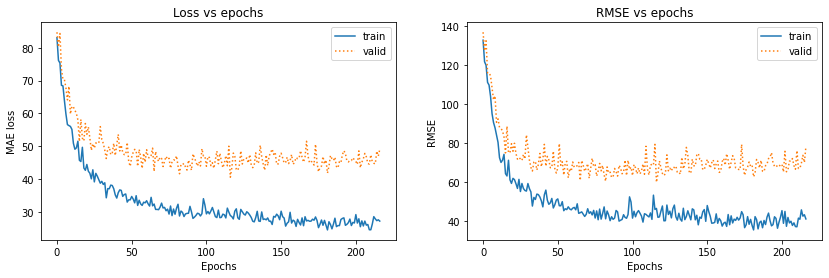

In [101]:
# Plot the learning curves

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(history.history['loss'][10:], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_loss'][10:], label='valid', color='C1', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MAE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(history.history['root_mean_squared_error'][10:], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_root_mean_squared_error'][10:], label='valid', color='C1', linestyle=':')
plt.title("RMSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("RMSE")
plt.legend()

plt.show()
print(simple_model.evaluate(val_dataset, return_dict=True, verbose=0))

## Load saved model

In [208]:
from models import get_simple_mlp_concentrations
import tensorflow as tf


simple_model_load = get_simple_mlp_concentrations(input_shape=(10000,), hidden_units=[256, 256])
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.MeanAbsoluteError()
acc = tf.keras.metrics.RootMeanSquaredError()
simple_model_load.compile(optimizer=opt, loss=loss, metrics=[acc])
status = tf.train.Checkpoint(model=simple_model_load).restore(tf.train.latest_checkpoint('../saved_models/concentrations')).expect_partial()
status.assert_existing_objects_matched()

{'loss': 35.863948822021484, 'root_mean_squared_error': 53.04957580566406}
{'loss': 49.04244613647461, 'root_mean_squared_error': 78.0054931640625}


# Performances:

## Plot the concentrations for a random exmple of the validation dataset

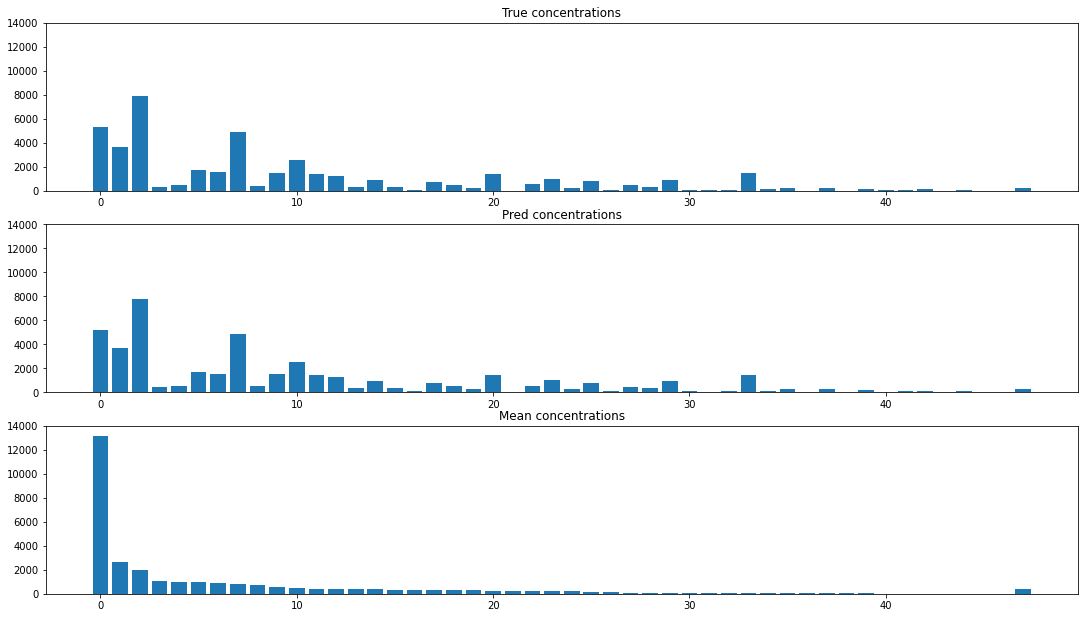

['Creatinine' 'Hippuric_acid' 'Citric_acid' 'Glycine' 'TMAO' 'Histidine'
 'phenylacetylglutamine' 'Taurine' 'glycolic_acid' 'Formate' 'Glutamine'
 'Lactate' 'lysine' 'cis-aconitic_acid' 'L_Tyrosine' 'Creatine'
 'Dimethylamine' 'guanidoacetic_acid' 'p-cresol_sulfate' 'L-alanine'
 'Arabitol' 'Isocitrate' 'Betaine' 'N-methylnicotinic_acid' 'acetate'
 'succinic_acid' 'Threonic_acid' 'Trimethylamine'
 'p-Hydroxyphenylacetic acid' 'beta-D-fructose' 'Dimethylglycine' 'NMND'
 '2-oxoglutarate' 'Galactose' 'Phenylacetate' 'L-carnosine' 'leucine'
 'Malic_acid' '2_hydroxybutyrate' 'Methionine' 'Isoleucine'
 'L-Glutamic_acid' 'citrulline' '2_deoxycytidine'
 'N-Acetyl-L-aspartic_acid' '2_deoxyadenosine' 'n-butyrate' 'L-serine']


In [106]:
import matplotlib.pyplot as plt
import numpy as np

filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)

filename_concentrations = '../data/concentration_data/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

metab_number = range(48)
for parsed_record in val_dataset.shuffle(1000).take(1):
    true_concentration = parsed_record[1][0].numpy()
    pred_concentration = simple_model_load(parsed_record[0])[0].numpy()


fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches(18.5, 10.5)

ax1.bar(metab_number,true_concentration)
ax1.set_title("True concentrations")
ax1.set_ylim(0, 14000)

ax2.bar(metab_number, pred_concentration)
ax2.set_title("Pred concentrations")
ax2.set_ylim(0, 14000)

ax3.bar(metab_number, mean_concentrations)
ax3.set_title("Mean concentrations")
ax3.set_ylim(0, 14000)

plt.show()

print(metabolites)



# RMSE

In [259]:
print('Validation: ', simple_model_load.evaluate(val_dataset, return_dict=True, verbose=0))
print('Train: ', simple_model_load.evaluate(train_dataset, return_dict=True, verbose=0))

Validation:  {'loss': 35.863948822021484, 'root_mean_squared_error': 53.04957580566406}
Train:  {'loss': 19.248687744140625, 'root_mean_squared_error': 27.2247257232666}


## Compute element wise RMSE

In [290]:
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)
y_pred = simple_model_load.predict(val_dataset)
true_val = []
for batch in val_dataset:
    true_val.append(batch[1])
y_val = tf.concat(true_val, axis=0).numpy()
element_wise_rmse = tf.math.sqrt(tf.reduce_mean(tf.math.square(y_val - y_pred), axis=0)).numpy()
element_wise_rmse = pd.Series(element_wise_rmse, index=metabolites, name='RMSE')
mean_concentrations = pd.Series(0.3*mean_concentrations, index=metabolites, name='Mean concentrations')
rule_of_thumbs = pd.Series(element_wise_rmse < mean_concentrations, index=metabolites, name='< 0.3 mean')
print(pd.concat([element_wise_rmse, mean_concentrations, rule_of_thumbs], axis=1))
print(sum(rule_of_thumbs))

                                  RMSE  Mean concentrations  < 0.3 mean
Creatinine                  130.413061             3960.000        True
Hippuric_acid                78.699586              792.000        True
Citric_acid                  78.749951              606.600        True
Glycine                      85.647173              308.700        True
TMAO                         56.556828              294.624        True
Histidine                    53.238705              284.400        True
phenylacetylglutamine        42.132643              281.160        True
Taurine                      89.210222              250.272        True
glycolic_acid                60.314282              225.600        True
Formate                      91.060764              174.900        True
Glutamine                    72.920267              145.740        True
Lactate                      46.548491              132.300        True
lysine                       38.546043              126.720     